# Hotel Booking Demand Analysis: <br> Customer Segmentation and Cancelation Prediction

## Table of Contents
1. [Abstract](#abstract)
2. [Data Preparation](#data-preparation)  
    2.1 [Duplicate Removal](#duplicates)  
    2.2 [Missing Value Imputation](#missing-values)  
    2.3 [Column Transforming](#columns)  
    2.4 [Outlier Removal](#outliers)  
    2.4 [Summary](#summary-data-prep)  
3. [Exploratory Data Analysis](#exploratory-data-analysis)  
    3.1 [Numerical Features](#num-feat)  
    3.2 [Categorical Features](#cat-feat)  
4. [Data Processing](#data-process)
5. [Modeling](#modeling)  
    4.1 [Customer Segment](#segment)  
    4.2 [Cancelation Prediction](#prediction)
6. [Discussion](#discussion)

<a id='abstract'></a>
# 1. Abstract


In this project, data analysis is conducted on a real-world dataset named *Hotel Bookings Demand*, which is the booking records provided by two hotels, one located in city and the other located in resorts, in Portugal from 2015 to 2017. The hotel manager is interested in teh following two questions:
- How to predict if a customer would cancel the booking? 
- Are there any behavior patterns in the customer by which they can be segmented into groups, so that I propose different promotions for them? 

To answer the questions, customer segment and cancelation prediction are investigated based on the dateset. 

- Customer segment is to divide customers into distinct groups, each of which shows distinct characteristics, so that we can obtain deeper insights on cutomer booking behaviors. Customer segment is done by dimension reduction followed by hierarchical clustering. 
- Cancelation prediction is to predict whether a booking will be canceled or not. It is done by applying Random Forest Classifier.

It is found that there are 7 customer groups with distinct booking behaviors. The cancelation prediction has achieved a accuracy of 80% and 79% for train and test set, respectively.

> **Data Source**
<br>
The dataset is accessible on [Kaggle.com](https://www.kaggle.com/jessemostipak/hotel-booking-demand/data), being firstly published in [this paper](https://www.sciencedirect.com/science/article/pii/S2352340918315191).


<a id='data-preparation'></a>
# 2. Data Preparation


In [1]:
import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances, make_scorer, mean_squared_error, classification_report, confusion_matrix

C:\Users\sheng\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
raw_df = pd.read_csv('data/hotel_bookings.csv')
raw_df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


<a id='duplicates'></a>
## 2.1. Duplicate Removal

In [3]:
print('Shape of data frame is: ', raw_df.shape)
print('Number of duplicates rows:', raw_df.shape[0] - raw_df.drop_duplicates().shape[0])

Shape of data frame is:  (119390, 32)
Number of duplicates rows: 31994


Aggregate duplicate rows and keep the counts as a new column namend `count_of_record`

In [4]:
df = raw_df.copy()
# groupby will ingnore missing values
# hence, temporarily fill missing values with a temporary mark to apply groupby
df = df.fillna('nan_temp_mark')
df = df.groupby(df.columns.tolist(),as_index=True).size().reset_index()
df = df.rename(columns={0: 'count_of_record'})
# convert the temporary mark back to missing values
df = df.replace('nan_temp_mark', np.nan)
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,count_of_record
0,City Hotel,0,0,2015,August,31,1,0,1,2,...,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-08-02,1
1,City Hotel,0,0,2015,August,32,3,1,0,2,...,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-08-04,1
2,City Hotel,0,0,2015,August,32,3,1,0,2,...,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-08-04,1
3,City Hotel,0,0,2015,August,32,3,1,2,1,...,NaN,40.0,0,Group,65.0,0,0,Check-Out,2015-08-06,1
4,City Hotel,0,0,2015,August,32,4,0,1,2,...,9.0,NaN,0,Transient,90.0,0,0,Check-Out,2015-08-05,1


In [5]:
print('After removing duplicate rows, the shape of data frame is:', df.shape)

After removing duplicate rows, the shape of data frame is: (87396, 33)


<a id='missing-values'></a>
## 2.2. Missing Values Imputation

In [6]:
missing_value_percent = df.isnull().sum() / df.shape[0] 
missing_value_percent[missing_value_percent != 0]

children    0.000046
country     0.005172
agent       0.139514
company     0.939826
dtype: float64

In [7]:
# imputation
df = df.fillna({
    'children': 0, 
    'agent': 'NA', # N/A
    'company': 0, # N/A
    'country': 'UNK' # unknown
})

<a id='columns'></a>
## 2.3. Columns Transforming

### Company

In [8]:
df['company'].value_counts()

0.0      82137
40.0       851
223.0      503
45.0       238
153.0      206
         ...  
35.0         1
420.0        1
54.0         1
368.0        1
142.0        1
Name: company, Length: 353, dtype: int64

In [9]:
df['company']
df['company'] = df.company.apply(lambda x: 1 if x else 0)
df.company.value_counts()

0    82137
1     5259
Name: company, dtype: int64

### Country and Agent

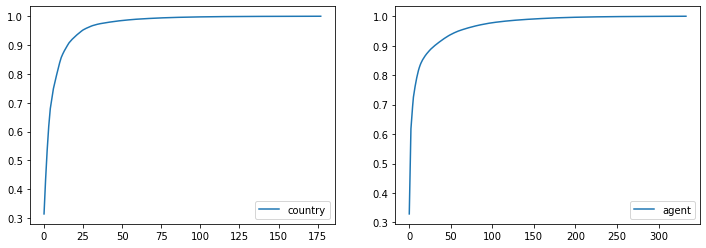

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
df.country.value_counts().cumsum().apply(lambda x: x / df.shape[0]).reset_index().plot(y='country',ax=axes[0]);
df.agent.value_counts().cumsum().apply(lambda x: x / df.shape[0]).reset_index().plot(y='agent', ax=axes[1]);

In [11]:
def country_process(df, top=None):
    if top:
        all_countries = df.country.value_counts().index.tolist()
        if 'UNK' in all_countries:
            all_countries.remove('UNK')
        top_countries = set(all_countries[:top])
    return df.country.apply(lambda x: x if x in top_countries else 'OTHER')

def agent_process(df, top=None):
    if top:
        top_agents = df.agent.value_counts().head(top).index.tolist()
        top_agents = set(top_agents)
    return df.agent.apply(lambda x: x if x in top_agents else 'OTHER')

df['country'] = country_process(df, 3)
df['agent'] = agent_process(df, 3)

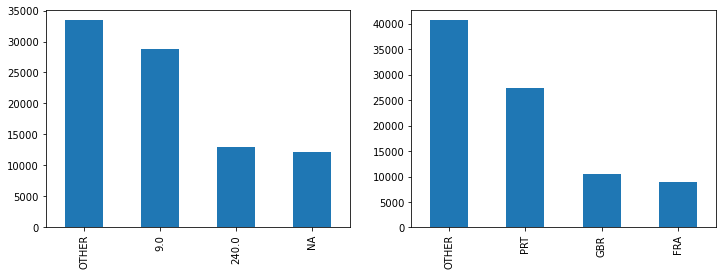

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
df.agent.value_counts().plot.bar(ax=axes[0]);
df.country.value_counts().plot.bar(ax=axes[1]);

### Month

In [13]:
month_to_ordinal = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}
df['arrival_date_month'] = df.arrival_date_month.apply(lambda m: month_to_ordinal[m])

### reservation_status_date

In [14]:
df.reservation_status_date = pd.to_datetime(df.reservation_status_date)
df[['reservation_status_date']].describe()

,reservation_status_date
count,87396
unique,926
top,2016-02-14 00:00:00
freq,211
first,2014-10-17 00:00:00
last,2017-09-14 00:00:00


<a id='outliers'></a>
## 2.4. Outlier Removal

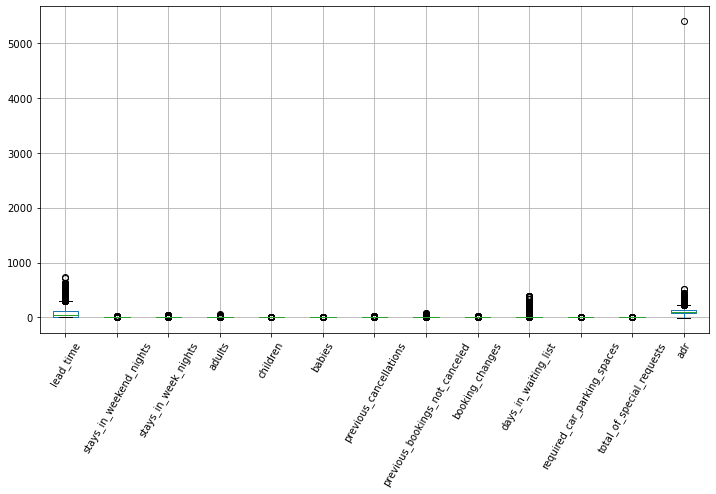

In [15]:
cols = [
    'lead_time',
    'stays_in_weekend_nights','stays_in_week_nights',
    'adults', 'children', 'babies',
    'previous_cancellations','previous_bookings_not_canceled',
    'booking_changes', 'days_in_waiting_list', 
    'required_car_parking_spaces','total_of_special_requests',
    'adr'
]
df[cols].boxplot(rot=60, figsize=(12,6));

### Manually set threshold to filter outlier

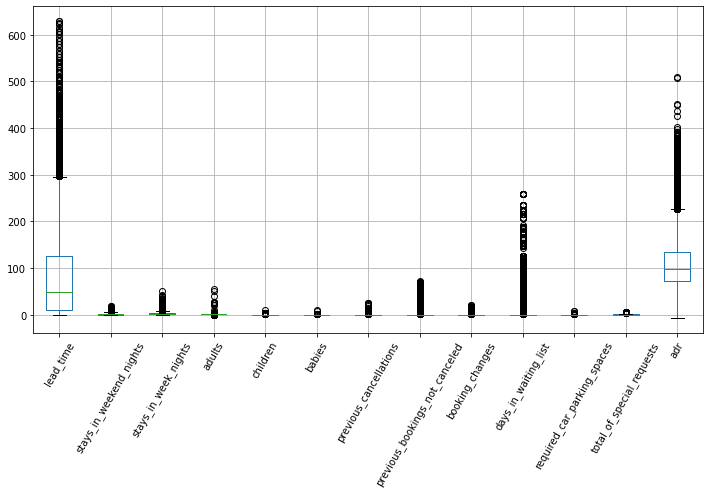

In [16]:
def remove_outliers(df):
    df = df[df.adr < 1000]
    df = df[df.lead_time < 700]
    df = df[df.days_in_waiting_list < 300]
    return df

df = remove_outliers(df)
df[cols].boxplot(rot=60, figsize=(12,6));

<a id='summary-data-prep'></a>
## 2.5. Summary of Data Preparation:

(i) remove outliers by manually setting thresholds.

(ii) remove duplicate rows and keep the counts.

(iii) fill missing values as: {
    'children': 0, 
    'agent': 'NA', # N/A
    'company': 0, # N/A
    'country': 'UNK' # unknown}
    
(iv) process columns (`company`, `agent`, `country`, `arrival_date_month`, `reservation_status_date`) as presented above.

<a id='exploratory-data-analysis'></a>
# 3. Exploratory Data Analysis

<a id='num-feat'></a>
## 3.1. Numerical Variables



### Distribution

In [17]:
num_feats = df.select_dtypes([np.int64, np.float64]).columns.tolist()
num_feats.remove('count_of_record')
print(f'Number of numerical features: {len(num_feats)}')

Number of numerical features: 20


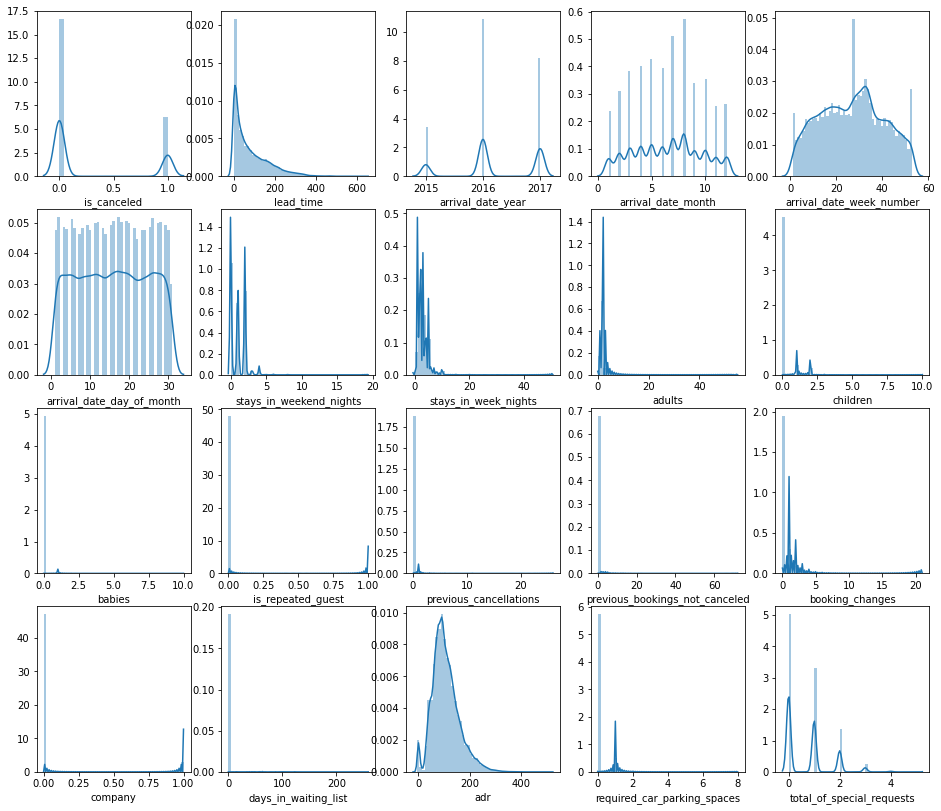

In [18]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(16, 14))
for col, ax in zip(num_feats, axes.flatten()):
    sns.distplot(df[col], ax=ax)
    ax.axis('tight')

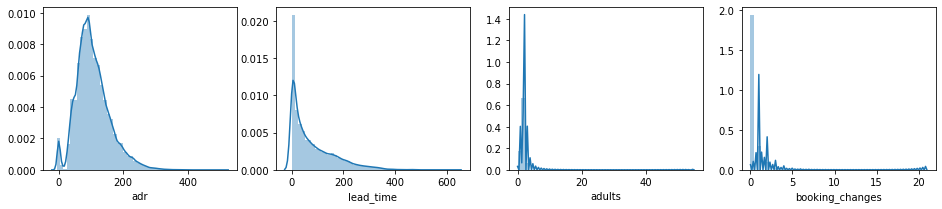

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 3))
for col, ax in zip(['adr', 'lead_time', 'adults', 'booking_changes'], axes):
    sns.distplot(df[col], ax=ax)
    ax.axis('tight')
plt.savefig('distribution.jpg',bbox_inches = 'tight')

In [ ]:
(df == 'scott').sum()

> Note: 
<br>
Except for `adr` (average daily rate), numerical features in the dataset are **highly skewed** showing a long right tail. It is easy to understand it because they tend to show a value closed to zero. For example, most `adults` are 1 or 2; most `booking_changes` are 0. For such distributions, it is not perfect to identify outliers as those with z-score > 3. Another way is to transform distributions into a normal-distribution-like one using a function like y=lg(x+1), but, for highly skewed features like `previous_cancelation` or `children`, it is still not good enough.
<br>
Therefore, linear-based models, like linear regression and logistic regreesion, are not good models to make a prediction, while tree-based models is a good choice for calcenlation prediction, due to their insensitivity of outliers and distribution.

### Correlations

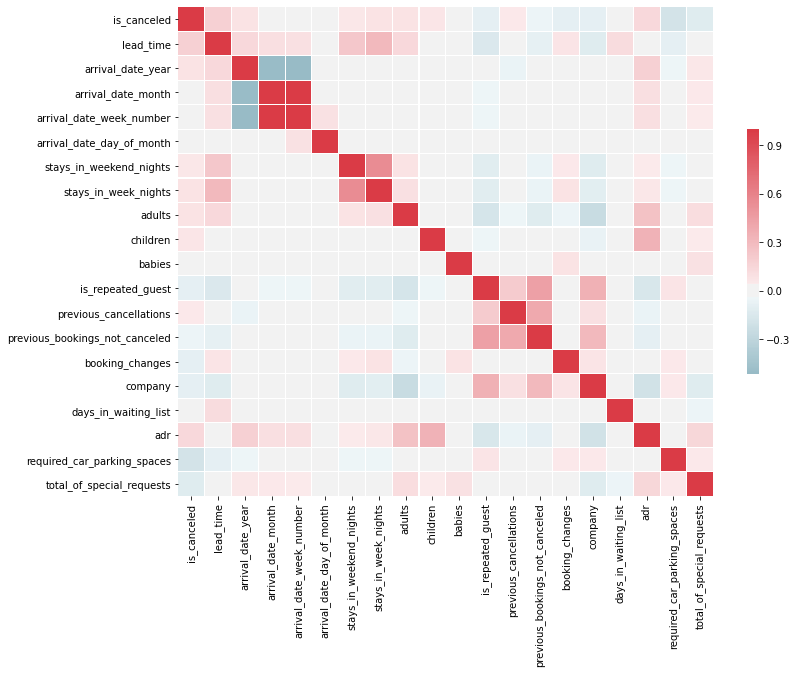

In [20]:
f, ax = plt.subplots(figsize=(12, 9))
ax = sns.heatmap(
    df.drop(columns=['count_of_record']).corr(),
    cmap=sns.diverging_palette(220, 10, as_cmap=True), 
    center=0, square=False, linewidths=.1,
    cbar_kws={"shrink": .5},
);
plt.savefig('corr.jpg',bbox_inches = 'tight')

Highly corerlated column pairs and possible reasons: 
1. (`arrival_date_month`, `arrival_date_week_number`): they are essentially the same thing.
2. (`stays_in_week_nights`, `stays_in_weekend_nights`): when a guest stays long, like a month, then of course both variables will increase simultaneously. 
3. (`is_repeated_guest`, `previous_bookings_not_canceled`): only repeated guest will have non-zero cancelation history. It is worth mention that the correlation of (`is_repeated_guest`, `previous_bookings_canceled`) is much smaller than (`is_repeated_guest`, `previous_bookings_not_canceled`), which indicates repeated guest tends not to be cancel a booking.
4. (`previous_bookings_canceled`, `previous_bookings_not_canceled`): they show a positive high correlation due to a ceitain guest usually have a stable cancelation rate. Hence the two variables tend to increase simultaneous.
5. (`adr`, `children`): the more children, the higher average daily rate.
6. (`company`, `is_repeated_guest`): the booking cost of repeated guest is usually paid by a company. (business-purpose travel)

### Pairplot

C:\Users\sheng\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\sheng\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


time spent in plotting: 58.14 s


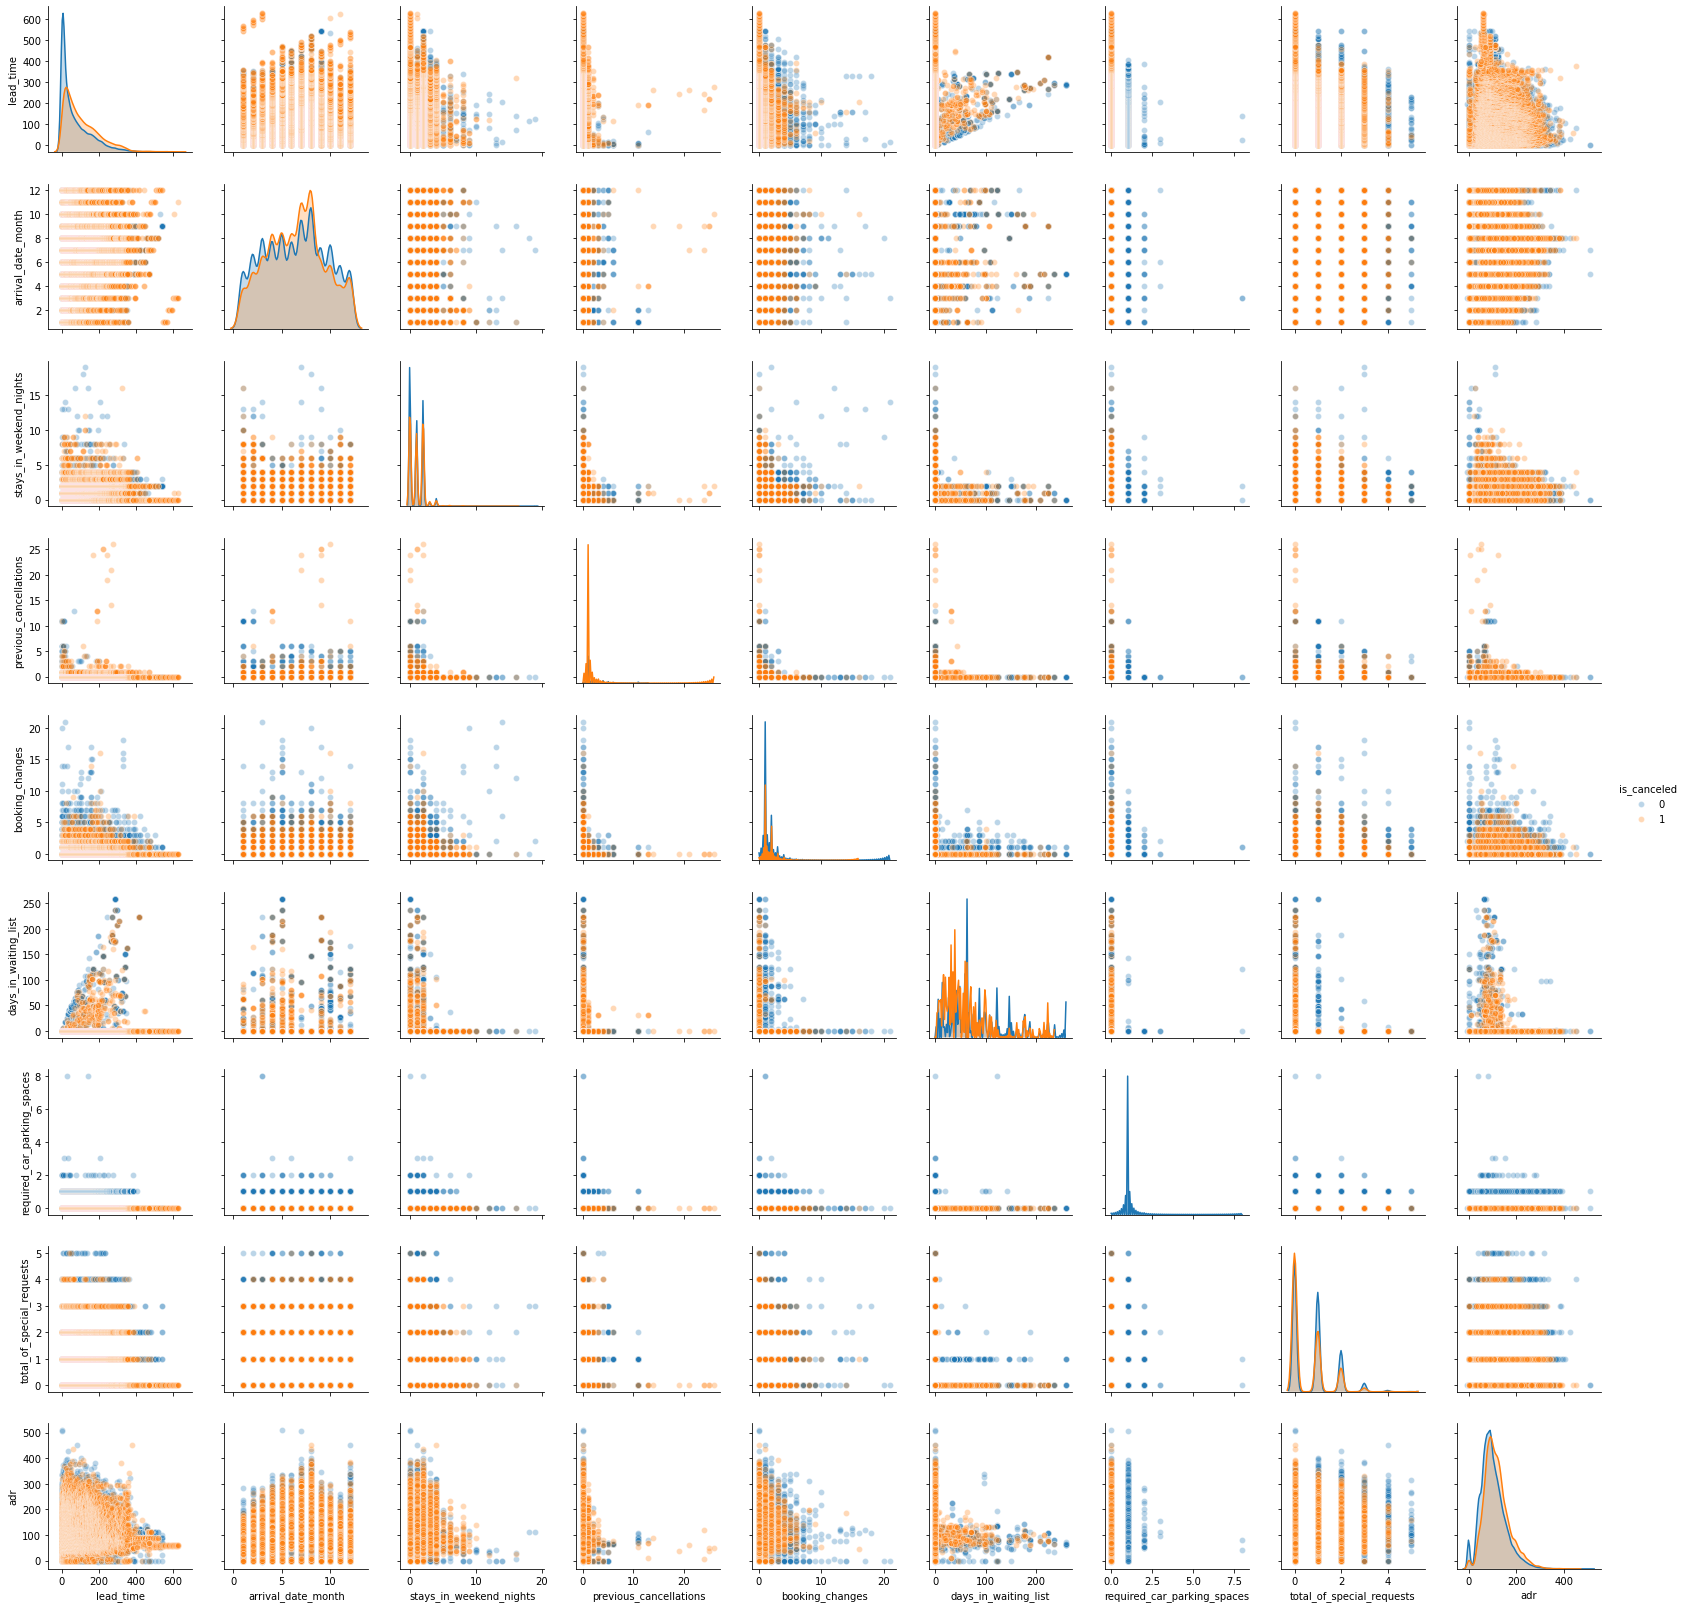

In [21]:
# time the plotting
tic = time.time()
# show pair plot
sns.pairplot(
    df, 
    vars=[
        'lead_time',
        'arrival_date_month',
        'stays_in_weekend_nights',
        'previous_cancellations',
        'booking_changes', 'days_in_waiting_list', 
        'required_car_parking_spaces','total_of_special_requests',
        'adr'
    ],
    hue="is_canceled",
    plot_kws={'alpha': 0.3}
);
toc = time.time()
print('time spent in plotting: {:.2f} s'.format(toc - tic))

> The purpose of pairplot is to investigate the distribution a pair of variables, as well as if the ditributions are dependent on the label `is_canceled`. Canceled and not canceled bookings are presented in orange and blue, spectively. It can be observed int pairplot:
1. `required_car_parking_spaces` row: the parking spaces of canceled bookings are 0.
2. `booking_changes` row: the upper limit of booking changes for not-canceled bookings are largert than that for canceled bookings.
3. `lead_time` and `days_in_waiting_list` is showing a linear-like relationship.

<a id='cat-feat'></a>
## 3.2. Categorical Features

### Booking Demand by Month

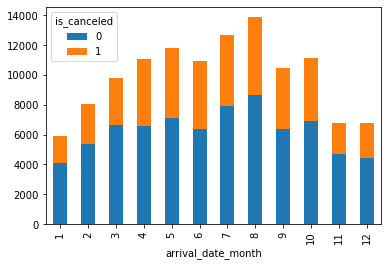

In [22]:
ax = pd.pivot_table(df, index='arrival_date_month', columns='is_canceled', values='count_of_record', aggfunc='sum').plot.bar(stacked=True);
plt.savefig('demand.jpg',bbox_inches = 'tight')

> In high-demand months (July and August), the cancenlation rate is also slightly higher. A possible reason may be the increased number of toursists in summer as the notels are located in north semisphere. 

### Cancelation on Repeated Customer, Customer Type and Total Special Requests

In [23]:
pd.pivot_table(df, index='is_repeated_guest', columns='customer_type',aggfunc='count')['adr']

customer_type,Contract,Group,Transient,Transient-Party
is_repeated_guest,,,,
0,3106,388,69041,11431
1,33,156,2936,290


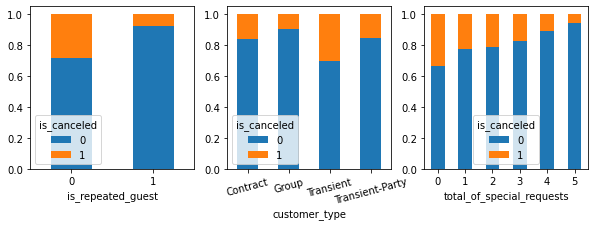

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,3))

temp = pd.pivot_table(df, index='is_repeated_guest', columns='is_canceled',aggfunc='count')['adr']
temp.div(temp.sum(axis=1), axis=0).plot.bar(rot=0, stacked = True, ax=axs[0]);

temp = pd.pivot_table(df, index='customer_type', columns='is_canceled',aggfunc='count')['adr']
temp.div(temp.sum(axis=1), axis=0).plot.bar(rot=15, stacked = True, ax=axs[1]);

temp = pd.pivot_table(df, index='total_of_special_requests', columns='is_canceled',aggfunc='count')['adr']
temp.div(temp.sum(axis=1), axis=0).plot.bar(rot=0, stacked = True, ax=axs[2]);

plt.savefig('cancel_customer.jpg',bbox_inches = 'tight')

> Repeated guests are of a smaller percentage of cancelation.
> Bookings with more total special requests is less likely to cancel.

### Cancelation on Room Type

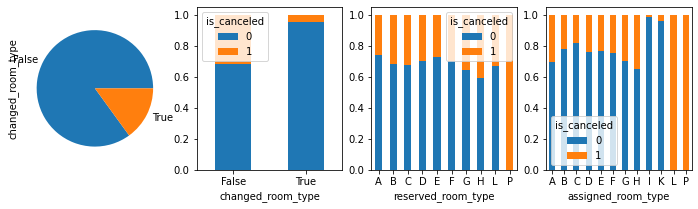

In [25]:
df['changed_room_type'] = df.reserved_room_type != df.assigned_room_type
df[['changed_room_type','reserved_room_type','assigned_room_type']]

# plots
fig, axs = plt.subplots(nrows=1,ncols=4, figsize=(12,3))

df['changed_room_type'].value_counts().plot.pie(ax=axs[0])

temp1 = pd.pivot_table(df, index='changed_room_type', columns='is_canceled',aggfunc='count')['adr']
temp1.div(temp1.sum(axis=1), axis=0).plot.bar(stacked = True,ax=axs[1], rot=0);

temp2 = pd.pivot_table(df, index='reserved_room_type', columns='is_canceled',aggfunc='count')['adr']
temp2.div(temp2.sum(axis=1), axis=0).plot.bar(stacked = True,ax=axs[2], rot=0);

temp3 = pd.pivot_table(df, index='assigned_room_type', columns='is_canceled',aggfunc='count')['adr']
temp3.div(temp3.sum(axis=1), axis=0).plot.bar(stacked = True,ax=axs[3], rot=0);

plt.savefig('room_vs_cancel.jpg',bbox_inches = 'tight')

> **New useful feature**! It can be observed that the cancelation percentage of the guests, whose assigned room type is different from reserved, is much lower than that of the guests whose assigned room type is the same as reserved. A possible situation can be that many guests prefer to change their room type after booking. If the change is approved by the hotel, they are satisfied so that they tend not to cancel the booking. 

> **Discuss on data leakage**: It causes my concerns if some of the valus in `assigned_room_type` is assigned when the guests show up in the hotel. If so, the column causes data leakage. Considering the two facts that (i) the paper where the data set comes from mentions that the dataset is for the prupose of cancelation prediction, indicating no data-leaking features, and (ii) there are records of labeled as both canceled and room-type-changed, I prefer to consider `assigned_room_type`, as well as `changed_room_type`, as a good feature rather than a bad one leading to data leakage.

<a id='data-process'></a>
# 4. Data Process

In [65]:
###
# cleaning
###

def remove_outliers(df):
    df = df[df.adr < 1000]
    df = df[df.lead_time < 700]
    df = df[df.days_in_waiting_list < 300]
    return df

def drop_duplicates(df):
    df = df.fillna('nan_temp_mark')
    df = df.groupby(df.columns.tolist(),as_index=True).size().reset_index()
    df = df.rename(columns={0: 'count_of_record'})
    # convert the temporary mark back to missing values
    df = df.replace('nan_temp_mark', np.nan)
    return df

def simple_cleaning(df):
    # remove outliers
    df = remove_outliers(raw_df)
    # remove duplicates
    df = drop_duplicates(df)
    # drop columns not used for cancelation prediction
    df = df.drop(columns=['reservation_status_date', 'reservation_status','count_of_record'])
    return df




###
# transform
###

class Data_Transformer():
    """
    - process the raw data
    - can be integrated in skelarn pipeline
    """
    def __init__(self, ntop_country=3, ntop_agent=3):
        self.na_filler = {
            'children': 0, 
            'agent': 'NA', # N/A
            'company': 0, # N/A
            'country': 'UNK' # unknown
        }
        self.month_to_ordinal = {
            'January': 1,
            'February': 2,
            'March': 3,
            'April': 4,
            'May': 5,
            'June': 6,
            'July': 7,
            'August': 8,
            'September': 9,
            'October': 10,
            'November': 11,
            'December': 12
        }
        self.ntop_country = ntop_country
        self.ntop_agent = ntop_agent
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        # X is a datafrmae
        df = X
        # fill missing values according to self.na_filler
        df = df.fillna(self.na_filler)
        # mark company cell as 1 if there is a value, 0 if missing value
        df['company'] = df.company.apply(lambda x: 1 if x else 0)
        # keep the top-n-frequent companies as they are, while mark others as 'OTHER'
        df['country'] = self.country_process(df, self.ntop_country)
        # keep the top-n-frequent agents as they are, while mark others as 'OTHER'
        df['agent'] = self.agent_process(df, self.ntop_agent)
        # convert months to ordinals
        df['arrival_date_month'] = df.arrival_date_month.apply(lambda m: self.month_to_ordinal[m])
        # feature engineering
        df['changed_room_type'] = df.reserved_room_type != df.assigned_room_type
        return df
        
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)
    
    def country_process(self, df, top):
        all_countries = df.country.value_counts().index.tolist()
        if self.na_filler['country'] in all_countries:
            all_countries.remove(self.na_filler['country'])
        top_countries = set(all_countries[:top])
        return df.country.apply(lambda x: x if x in top_countries else 'OTHER')

    def agent_process(self, df, top):
        top_agents = df.agent.value_counts().head(top).index.tolist()
        top_agents = set(top_agents)
        return df.agent.apply(lambda x: str(x) if x in top_agents else 'OTHER')

    
##########################
# all-in-one data processor
##########################
def process_data(raw_df, target='is_canceled'):
    
    # cleaning
    df = simple_cleaning(raw_df)

    # features and target
    features = df.columns.tolist()
    features.remove(target)
    
    X = df[features]
    y = df[target]

    # apply the data transformer
    dt = Data_Transformer()
    X = dt.fit_transform(X)

    return X, y


In [66]:
target ='is_canceled'
X, y = process_data(raw_df, target)

# numerical and categorical geatures

num_features = X.select_dtypes([np.float64, np.int64, bool]).columns.tolist()
cat_features = X.select_dtypes([np.object]).columns.tolist()
print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')
print(f"\nnumeric features: {len(num_features)}\n{num_features}")
print(f"\ncategorical features: {len(cat_features)}\n{cat_features}")
print(f"\ntarget: {target}")

Shape of X: (87381, 30)
Shape of y: (87381,)

numeric features: 20
['lead_time', 'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'company', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'changed_room_type']

categorical features: 10
['hotel', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'agent', 'customer_type']

target: is_canceled


<a id='modeling'></a>
# 5. Modeling


<a id='segment'></a>
## 5.1. Customer / Booking Segment

Before calcenlation prediction, I would like to group customers (or booking records) into distinct groups and extract the characteristics of each group. The purpose of customer segment is as follows:

- Get more insights on the behaviors of different type of customers
- Adding a new feature `customer_group` as a new feature for calcelation prediction. As part of feature enginerring, the new label is expected to provide more insights on customers. It will be discussed at the end of the section.
- Note that `customer_group` is different from `customer_type`, the latter of which marks customers as `Transient`, `Transient-Party`, `Contract` and `Group`.

In [67]:
# use only numerical features for cluster

# rescale
scaler = StandardScaler()
df = scaler.fit_transform(X[num_features])

# convert to dataframe
df = pd.DataFrame(df, columns=num_features)
df

,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,changed_room_type
0,-0.929302,-1.763990,0.492211,0.304448,-1.676802,-0.974497,-0.791737,0.198271,-0.304137,-0.095296,-0.201671,-0.082396,-0.106246,-0.373418,-0.253059,-0.077337,-0.601385,-0.299198,-0.839774,-0.420062
1,-0.929302,-1.763990,0.492211,0.377577,-1.450435,-0.005180,-1.278860,0.198271,-0.304137,-0.095296,-0.201671,-0.082396,-0.106246,-0.373418,-0.253059,-0.077337,-2.043167,-0.299198,-0.839774,2.380599
2,-0.929302,-1.763990,0.492211,0.377577,-1.450435,-0.005180,-1.278860,0.198271,-0.304137,-0.095296,-0.201671,-0.082396,-0.106246,-0.373418,-0.253059,-0.077337,-2.043167,-0.299198,-0.839774,-0.420062
3,-0.929302,-1.763990,0.492211,0.377577,-1.450435,-0.005180,-0.304613,-1.397776,-0.304137,-0.095296,-0.201671,-0.082396,-0.106246,-0.373418,3.951647,-0.077337,-0.793623,-0.299198,-0.839774,-0.420062
4,-0.929302,-1.763990,0.492211,0.377577,-1.337251,-0.974497,-0.791737,0.198271,-0.304137,-0.095296,-0.201671,-0.082396,-0.106246,-0.373418,-0.253059,-0.077337,-0.313029,-0.299198,-0.839774,-0.420062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87376,4.518840,-0.306560,-0.476291,-0.499969,-0.431781,-0.974497,-0.304613,0.198271,-0.304137,-0.095296,-0.201671,-0.082396,-0.106246,-0.373418,-0.253059,-0.077337,-0.755175,-0.299198,-0.839774,-0.420062
87377,4.518840,-0.306560,-0.476291,-0.499969,-0.431781,-0.974497,-0.304613,0.198271,-0.304137,-0.095296,-0.201671,-0.082396,-0.106246,1.001853,-0.253059,-0.077337,-1.543349,-0.299198,-0.839774,-0.420062
87378,4.518840,-0.306560,-0.476291,-0.499969,-0.431781,-0.974497,-0.304613,0.198271,-0.304137,-0.095296,-0.201671,-0.082396,-0.106246,1.001853,-0.253059,-0.077337,-0.755175,-0.299198,-0.839774,-0.420062
87379,4.518840,-0.306560,-0.476291,-0.499969,-0.431781,-0.974497,-0.304613,0.198271,-0.304137,-0.095296,-0.201671,2.626349,-0.106246,-0.373418,-0.253059,-0.077337,-0.755175,-0.299198,-0.839774,-0.420062


### 5.1.1. Trial on Pilot Sample

In [68]:
pilot = df.sample(2000, random_state=42)
pilot.shape

(2000, 20)

#### PCA

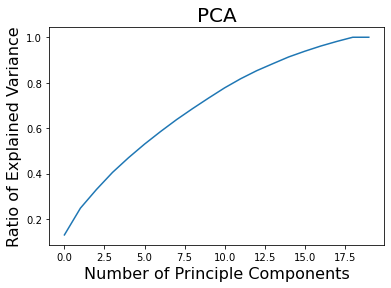

In [69]:
pca = PCA()
pca.fit(pilot)
plt.plot(pca.explained_variance_ratio_.cumsum());
plt.xlabel('Number of Principle Components', fontsize=16);
plt.ylabel('Ratio of Explained Variance', fontsize=16);
plt.title('PCA', fontsize=20);
plt.savefig('pca.jpg',bbox_inches = 'tight')

> There is no obvious "Elbow" on the curve of explained variance vs number of principle components. Hence, PCA is not a good enough for dimension reduction.

#### t-SNE

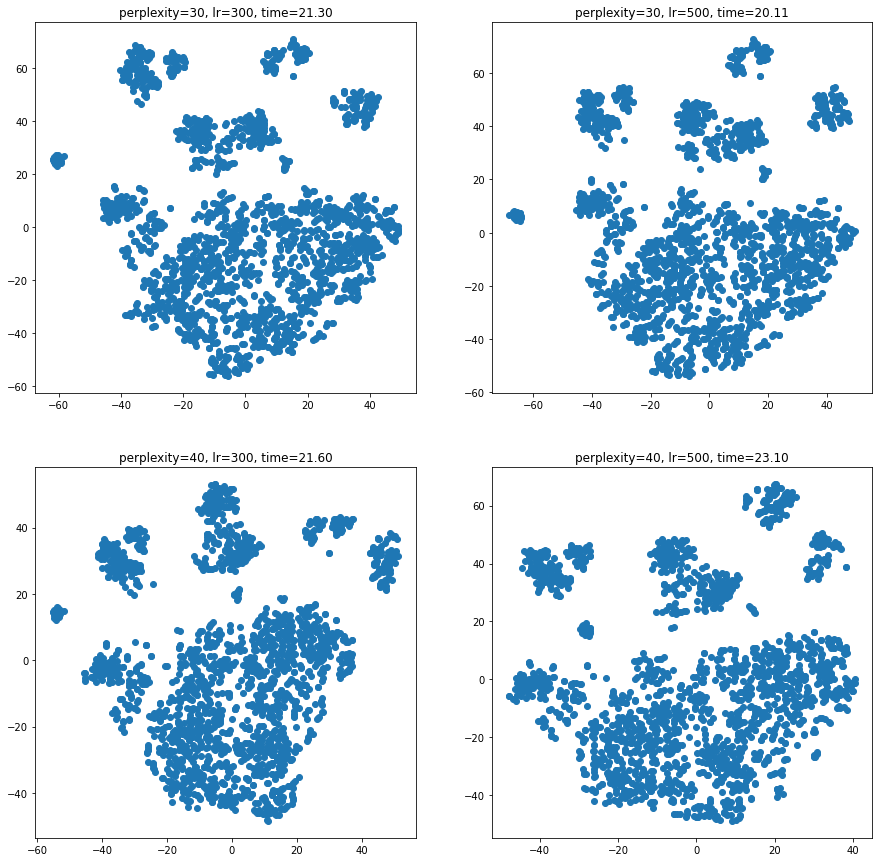

In [70]:
perplexities = [30, 40]
learning_rates = [300, 500]

fig, axs = plt.subplots(len(perplexities), len(learning_rates),figsize=(15,15))

for i, perplex in enumerate(perplexities):
    for j, lr in enumerate(learning_rates):
        
        tic = time.time()
        tsne = TSNE(
            n_components=2, 
            init='pca', 
            perplexity=perplex,
            learning_rate=lr,
            n_iter=1000,
            random_state=42,
            verbose=0,
            n_jobs=-1
        )
        X_temp = tsne.fit_transform(pilot)
        toc = time.time()

        axs[i, j].set_title(f'perplexity={perplex}, lr={lr}, time={toc-tic:.2f}')
        axs[i, j].scatter(X_temp[:, 0], X_temp[:, 1])
        axs[i, j].axis('tight')

> Here I will choose the first clustering in 1st row 1st col, because the clusters are more seperated from each other and  there are not too many 'outliers'.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.021s...
[t-SNE] Computed neighbors for 2000 samples in 0.234s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1.152135
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.720970
[t-SNE] KL divergence after 1000 iterations: 1.198713


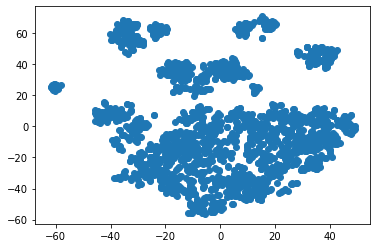

In [71]:
# pick the optimal params for t-SNE model
tsne = TSNE(
    n_components=2, 
    init='pca', 
    perplexity=30,
    learning_rate=300,
    random_state=42,
    verbose=1,
    n_jobs=-1
)
X_tsne = tsne.fit_transform(pilot)
plt.scatter(X_tsne[:,0], X_tsne[:,1]);

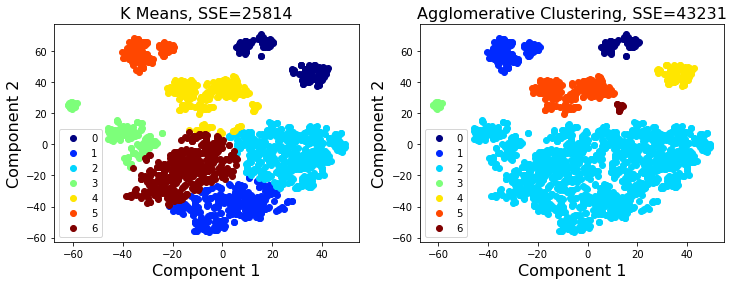

In [72]:
model_names = ['K Means', 'Agglomerative Clustering']
n_clusters = 7
clustering_models = [
    KMeans(
        n_clusters=n_clusters, 
        init='k-means++', 
        n_init=7, 
        max_iter=300,
        tol=1e-03,
        random_state=0
    ),
    AgglomerativeClustering(
        n_clusters=n_clusters, 
        affinity='euclidean', 
        linkage='single'       
    )
]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

for i in range(2):
    model = clustering_models[i].fit(X_tsne)
    y_tsne = model.labels_
    n_clusters = len(set(y_tsne))
    cluster_labels = np.unique(y_tsne)

    # calculate SSEs
    sse = 0
    for label in range(n_clusters):
        X_group = X_tsne[y_tsne == label]
        centroid = X_group.mean(axis=0).reshape(1,-1)
        sse += pairwise_distances(X_group, centroid, metric='euclidean').sum()

    
    # plot the labeled clusters
    cmap = plt.get_cmap('jet')
    colors = cmap(np.linspace(0, 1.0, len(set(y_tsne))))
    for label, color in zip(set(y_tsne), colors):
        axs[i].scatter(X_tsne[y_tsne==label, 0], X_tsne[y_tsne==label, 1], color=color,label=label);

    axs[i].set_title(f'{model_names[i]}, SSE={sse:.0f}', fontsize=16);
    axs[i].set_xlabel('Component 1', fontsize=16);
    axs[i].set_ylabel('Component 2', fontsize=16);
    axs[i].legend(loc='lower left');

plt.show();
fig.savefig('clustering.jpg', bbox_inches = 'tight');


>Despite higher SSE, Agglomeratigve Clustering shows better-labeled clusters compared to K Means. Therefore, Agglomeratigve Clustering will be selected as the clustering algorithm following t-SNE dimension reduction.

### 5.1.2. Extract Cluster Characteristics

In [73]:
df = X
X = X_tsne

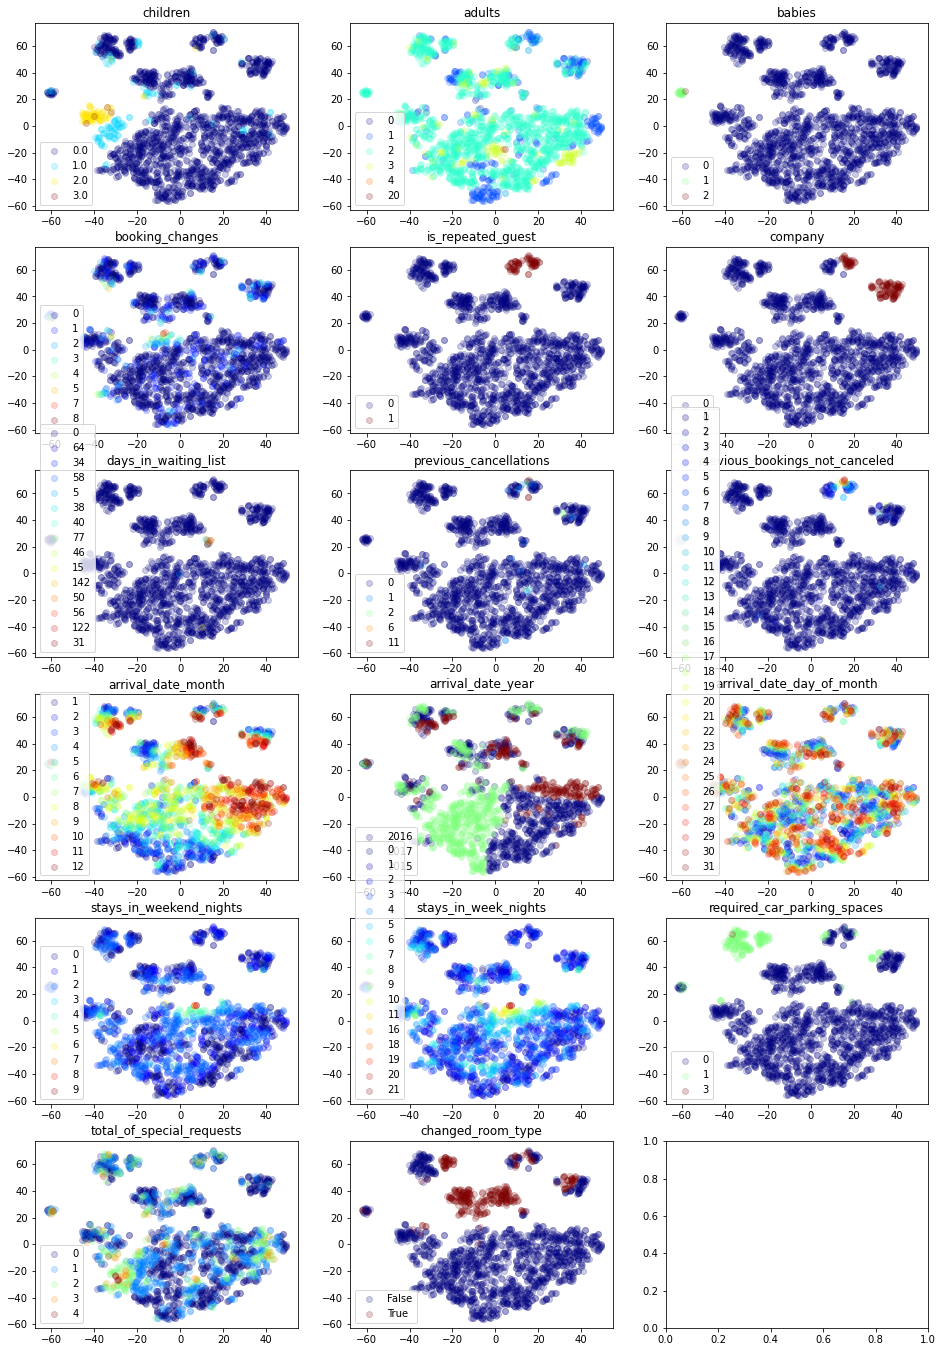

In [74]:
fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(16,24))
'''
feats = [
    'children','babies','is_repeated_guest', 'company',
    'days_in_waiting_list', 'previous_bookings_not_canceled',
    'required_car_parking_spaces','changed_room_type'
]
'''
feats = [
    'children','adults', 'babies',
    'booking_changes','is_repeated_guest', 'company',
    'days_in_waiting_list', 'previous_cancellations','previous_bookings_not_canceled',
    'arrival_date_month', 'arrival_date_year', 'arrival_date_day_of_month',
    'stays_in_weekend_nights', 'stays_in_week_nights',
    'required_car_parking_spaces','total_of_special_requests','changed_room_type'
]

for feat, ax in zip(feats, axs.flatten()):
    # group
    grouper = df.iloc[pilot.index][feat]
    labels = list(set(grouper))
    #print(labels)
    # color
    cmap = plt.get_cmap('jet')
    colors = cmap(np.linspace(0, 1.0, len(labels)))
    # plot
    for label, color in zip(labels, colors):
        mask = grouper == label
        ax.scatter(X[mask,0], X[mask,1], color=color, alpha=0.2, label=label);
    ax.legend(loc='lower left');
    ax.set_title(feat)
    
fig.savefig('coloring_groups.jpg', bbox_inches = 'tight');

#### A summary of Booking Segments / Clusters


| Cluster # | Characteristics                                                   |
| :-------- | :---------------------------------------------------------------- |
|         0 | precvious_booking_not_canceled > 0; is_repeated_guest == True     |
|         1 | required_car_parking_spaces > 0                                   |
|         2 | all bookings excluded by other clusters                           |
|         3 | babies > 0                                                        |
|         4 | company == 1                                                      |
|         5 | changed_room_type == True                                         |
|         6 | days_in_waiting_list > 0                                          |

### 5.1.3. Booking Segment (code)

In [36]:
def booking_segment(df, n_clusters=7, verbose=1, file_to_write='tsne.csv', write_to_file=False, n_samples=1000):

    # rescale
    scaler = StandardScaler()
    df = scaler.fit_transform(df)
    df = pd.DataFrame(df, columns=num_features)
    print('rescale done')

    # dimension reduction
    tsne = TSNE(
        n_components=2, 
        init='pca', 
        perplexity=30,
        learning_rate=300,
        random_state=42,
        verbose=verbose,
        n_jobs=-1
    )
    X = tsne.fit_transform(df.sample(n_samples))
    plt.scatter(X[:,0], X[:,1]);
    if write_to_file:
        pd.DataFrame(X).to_csv(file_to_write, header=None)
    print('dimension reduction done')


    # clustering
    model = AgglomerativeClustering(
        n_clusters=n_clusters, 
        affinity='euclidean', 
        linkage='single'       
    )
    model = model.fit(X)
    y = model.labels_
    cluster_labels = np.unique(y)
    print('clustering done')

    # plot the labeled clusters
    fig, ax = plt.subplots(figsize=(12,6))
    cmap = plt.get_cmap('jet')
    colors = cmap(np.linspace(0, 1.0, len(set(y))))
    for label, color in zip(set(y), colors):
        ax.scatter(X[y==label, 0], X[y==label, 1], color=color,label=label);

    ax.set_title(f'Agglomerative Clustering')
    ax.axis('tight')
    plt.legend();
    plt.show();
    
    return y


rescale done
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.011s...
[t-SNE] Computed neighbors for 1000 samples in 0.108s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.275832
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.971985
[t-SNE] KL divergence after 1000 iterations: 1.082981
dimension reduction done
clustering done


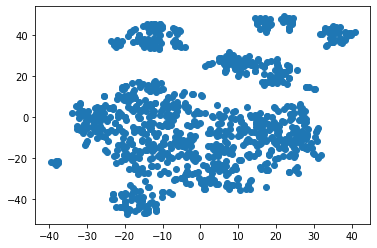

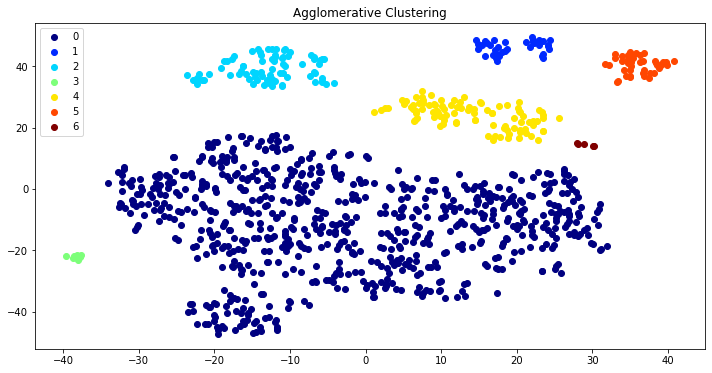

Time spent: 14.647581338882446 s


In [37]:
tic = time.time()

X, y = process_data(raw_df)
labels = booking_segment(X.select_dtypes([np.float64, np.int64, bool]))

toc = time.time()
print(f"Time spent: {toc-tic} s")

<a id='prediction'></a>
## 5.2. Cancelation Prediction

### 5.2.1. Model Selection

#### Hyperparameter tuning using *Grid Search* and *Cross Validation*

In [38]:
# get X and y
X, y = process_data(raw_df)

# split train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(f'size of train set: {X_train.shape}')
print(f'size of test set: {X_test.shape}')

# column transformer
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder())])

ct = ColumnTransformer(transformers=[
    ('num', numeric_transformer, make_column_selector(dtype_exclude="object")),
    ('cat', categorical_transformer, make_column_selector(dtype_include="object"))
])

X_train = ct.fit_transform(X_train)


# use MSE as the score in Grid Search
# MSE is set to be negative so that the lower socre the better 
mse = make_scorer(mean_squared_error,greater_is_better = False)

gsc = GridSearchCV(
        estimator=RandomForestClassifier(
            class_weight='balanced',
            bootstrap = True,
            max_samples = 5000
        ),
        param_grid={
            'max_depth': [5, 10],
            'max_features': [0.5, 'sqrt'],
            'n_estimators': [50, 100, 200],
            'min_samples_leaf': [2, 5],
            'min_samples_split': [5, 10]
        },
        cv=2, scoring=mse, verbose=1, n_jobs=-1)

grid_result = gsc.fit(X_train, y_train)
best_params = grid_result.best_params_

size of train set: (58545, 30)
size of test set: (28836, 30)
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  2.1min finished


#### Loss vs Number of Trees by Number of Features

In [39]:
print('The best parameters are:\n', best_params)

# filter cv_results_
# keep only the columns we need for plotting grid search results
gs_df = pd.DataFrame(grid_result.cv_results_)
col_filter = (
    (gs_df.param_min_samples_leaf == 2) 
    & (gs_df.param_min_samples_split == 5) 
    & (gs_df.param_max_depth == 10)
)
gs_df = gs_df[col_filter]
gs_df = gs_df[['param_n_estimators','param_max_features','mean_test_score']]

# this function is used to rename the values in max_features
def modify_max_features(x):
    if x == 0.5:
        return 'n/2'
    if x == 'sqrt':
        return 'sqrt(n)'
    
# rename the [None, 0.5, sqrt] to be [p, p/2, sqrt(p)]
gs_df.param_max_features = gs_df.param_max_features.apply(modify_max_features)
# reset MSE to be positive
gs_df.mean_test_score = - gs_df.mean_test_score
# take a look
gs_df

The best parameters are:
 {'max_depth': 10, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


,param_n_estimators,param_max_features,mean_test_score
24,50,n/2,0.204748
25,100,n/2,0.206320
26,200,n/2,0.203177
36,50,sqrt(n),0.211598
37,100,sqrt(n),0.213221
38,200,sqrt(n),0.212589


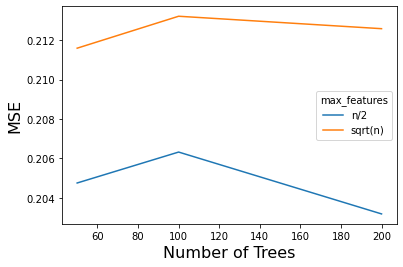

In [40]:
pvt = gs_df.pivot_table(index='param_n_estimators', columns='param_max_features', values='mean_test_score')
ax = pvt.plot();
ax.set_xlabel('Number of Trees', fontsize=16);
ax.set_ylabel('MSE', fontsize=16);
ax.legend(title='max_features', loc='best');
#ax.set_ylim(0.0038, 0.0052);

### 5.2.2. Best Model

In [41]:
# get X and y
X, y = process_data(raw_df)

# split train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# column transformer
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder())])

ct = ColumnTransformer(transformers=[
    ('num', numeric_transformer, make_column_selector(dtype_exclude="object")),
    ('cat', categorical_transformer, make_column_selector(dtype_include="object"))
])

cancel_predictor = Pipeline([
    ('ct', ct),
    ('rfc', RandomForestClassifier(
        class_weight='balanced',
        bootstrap = True,
        max_samples = 5000,
        min_samples_leaf= 2,
        min_samples_split = 5,
        max_depth=10, 
        max_features=0.5, 
        n_estimators=50
    ))
])

cancel_predictor = cancel_predictor.fit(X_train,y_train)

### 5.2.3. Feature Importance

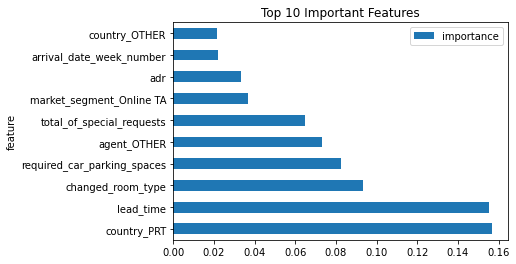

In [42]:
feat_names_num = cancel_predictor['ct'].transformers_[0][-1]
feat_names_cat = cancel_predictor['ct'].transformers_[1][-1]
feat_names_cat_encoded = cancel_predictor['ct'].transformers_[1][1]['onehot'].get_feature_names(cat_features).tolist()
feat_names = feat_names_num + feat_names_cat_encoded

feat_imp = pd.DataFrame()
feat_imp['feature'] = feat_names
feat_imp['importance'] = cancel_predictor['rfc'].feature_importances_
feat_imp.sort_values(by='importance', ascending=False).head(10).set_index('feature').plot.barh();
plt.title('Top 10 Important Features');

plt.savefig('feat_imp.jpg', bbox_inches = 'tight');

### 5.2.4. Model Performance

In [43]:
y_train_pred = cancel_predictor.predict(X_train)
y_test_pred = cancel_predictor.predict(X_test)

# classification report of train
print("1. Classification Report of train set:")
print(classification_report(y_train, y_train_pred))

# confusion matrix of train
print('2. Confusion Matrix of train set\n', confusion_matrix(y_train, y_train_pred))

# classification report of test
print("\n3. Classification Report of test set:")
print(classification_report(y_test, y_test_pred))

# confusion matrix of test
print('4. Confusion Matrix of test set\n', confusion_matrix(y_test, y_test_pred))

1. Classification Report of train set:
              precision    recall  f1-score   support

           0       0.94      0.77      0.84     42479
           1       0.58      0.87      0.70     16066

    accuracy                           0.79     58545
   macro avg       0.76      0.82      0.77     58545
weighted avg       0.84      0.79      0.80     58545

2. Confusion Matrix of train set
 [[32551  9928]
 [ 2113 13953]]

3. Classification Report of test set:
              precision    recall  f1-score   support

           0       0.93      0.76      0.84     20885
           1       0.58      0.85      0.69      7951

    accuracy                           0.79     28836
   macro avg       0.76      0.81      0.77     28836
weighted avg       0.83      0.79      0.80     28836

4. Confusion Matrix of test set
 [[15970  4915]
 [ 1172  6779]]


<a id='discussion'></a>
# 6. Discussion

## 6.1. Customer Segment
- PCA does not show an obvious elbow, indicating it will bot help much on dimension reduction. t-SNE is able to keep substructures while reducing dimension and performs greatly on generating a 2-D scatter plot with separatable islands. Therefore, t-SNE is used in the project, despite taht it is quite comtutaionally expensive compared to PCA.
- K means and Agglomerative Clustering are compared in clustering the 2-D dataset generated by t-SNE. Agglomerative Clustering shows a much better results, grouping observations into isolated groups. However, 87381 rows is too large for Agglomerative Clustering to handle due to its O(n^2) space complexity. Hence, customer segment is conducted on a smaller sample with 2000 rows randomly fetched from the whole dataset.
- An possible improvement is to scale suctomer segment from a pilot sample to the whole dataset. DBSCAN, a density-based clustering algorithm, can be a better candidate due to its lower space cost.

## 6.2. Cancelation Prediction
- Grid search with cross validation is used for hyperparameter tuning to select a better Random Forest model.
- Two features are found to be the most important: 
    - `country_PRT`: local customers in Portugal are found more likely to cancel a booking, which is understandable because foreign customers are more cautious on canceling bookings when traveling in another country.
    - `lead_time`: how long in advance the booking is made before arrival date. Early bookings are more likely to be canceled.